# Convolutional Neural Networks

Notebook by Corey Adams, some modifications by Bethany Lusch

Up until transformers, convolutions were *the* state of the art in computer vision.  In many ways and applications they still are!

Large Language Models, which are what we'll focus on the rest of the series after this lecture, are really good at ordered, *tokenized data.  But there is lots of data that isn't _implicitly_ ordered like `images`, and their more general cousins `graphs`.

Today's lecture focuses on computer vision models, and particularly on convolutional neural networks.  There are a ton of applications you can do with these, and not nearly enough time to get into them.  Check out the extra references file to see some publications to get you started if you want to learn more.

Tip: this notebook is much faster on the GPU!


## Convolutional Networks: A brief historical context

![ImageNet Accuracy by Yearh](ImageNet.png)

[reference](https://www.researchgate.net/publication/332452649_A_Roadmap_for_Foundational_Research_on_Artificial_Intelligence_in_Medical_Imaging_From_the_2018_NIHRSNAACRThe_Academy_Workshop)

In [1]:
import torch, torchvision

# Convolutional Building Blocks

We're going to go through some examples of building blocks for convolutional networks.  To help illustate some of these, let's use an image for examples:


In [2]:
from PIL import Image
# wget line useful in Google Colab
! curl https://raw.githubusercontent.com/argonne-lcf/ai-science-training-series/main/03_advanced_neural_networks/ALCF-Staff.jpg --output ALCF-Staff.jpg
alcf_image = Image.open("ALCF-Staff.jpg")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  408k  100  408k    0     0  1929k      0 --:--:-- --:--:-- --:--:-- 1952k


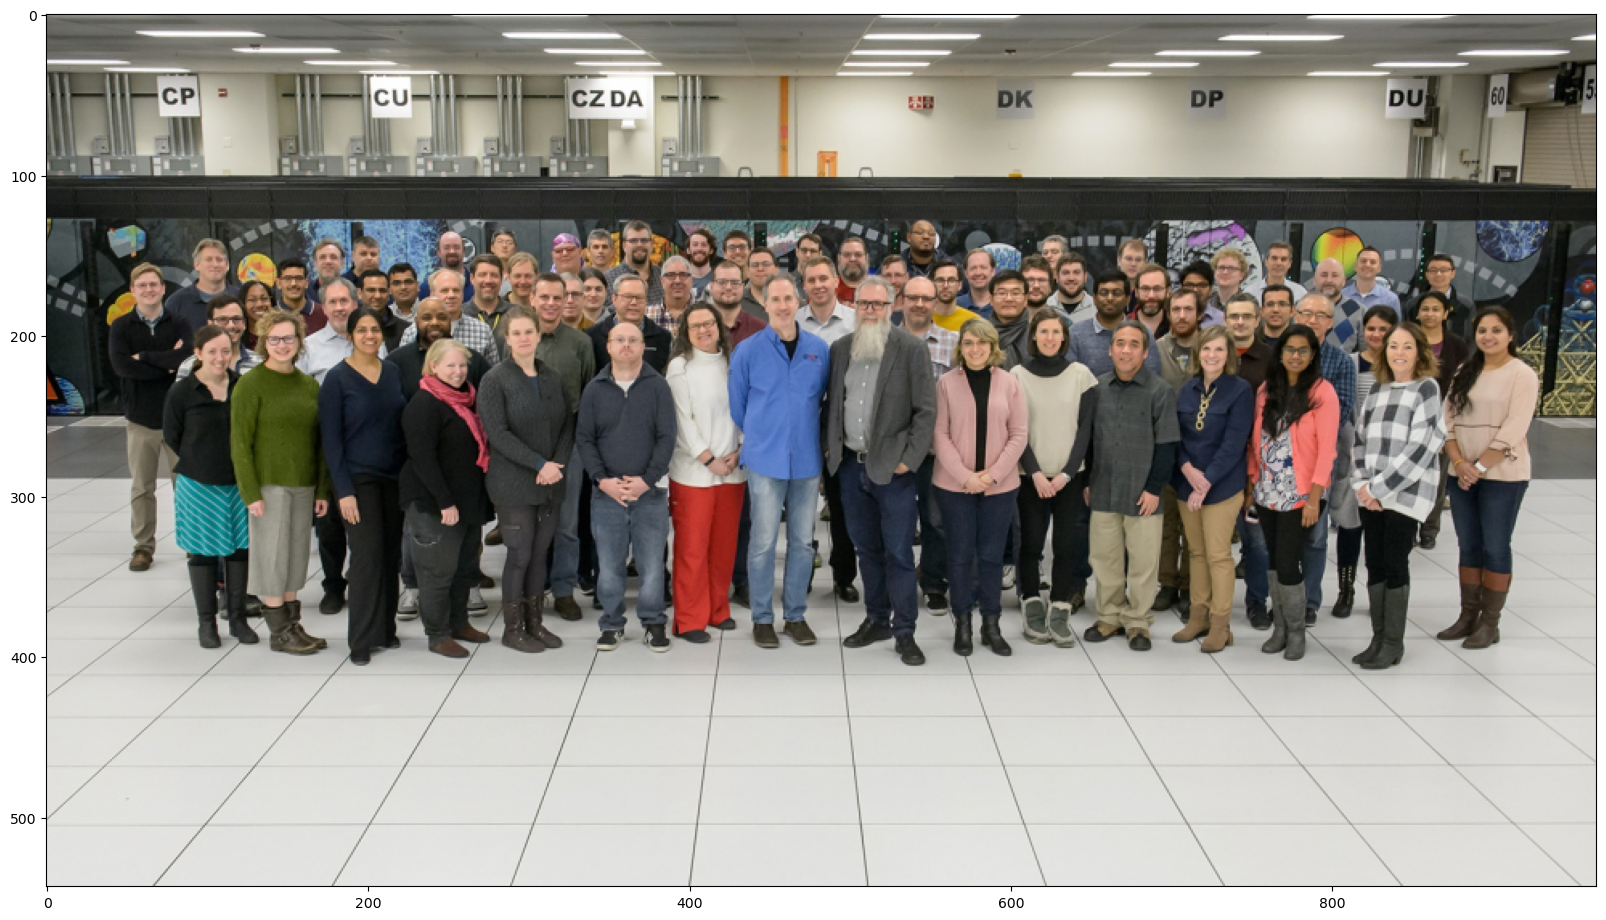

In [3]:
from matplotlib import pyplot as plt
figure = plt.figure(figsize=(20,20))
plt.imshow(alcf_image)
plt.show()

## Convolutions

Convolutions are a restriction of - and a specialization of - dense linear layers.  A convolution of an image produces another image, and each output pixel is a function of only it's local neighborhood of points.  This is called an _inductive bias_ and is a big reason why convolutions work for image data: neighboring pixels are correlated and you can operate on just those pixels at a time.

See examples of convolutions [here](https://github.com/vdumoulin/conv_arithmetic)

![image-2.png](conv_eqn.png)

![image.png](conv.png)


torch.Size([1, 3, 529, 951])
torch.Size([1, 3, 543, 965])


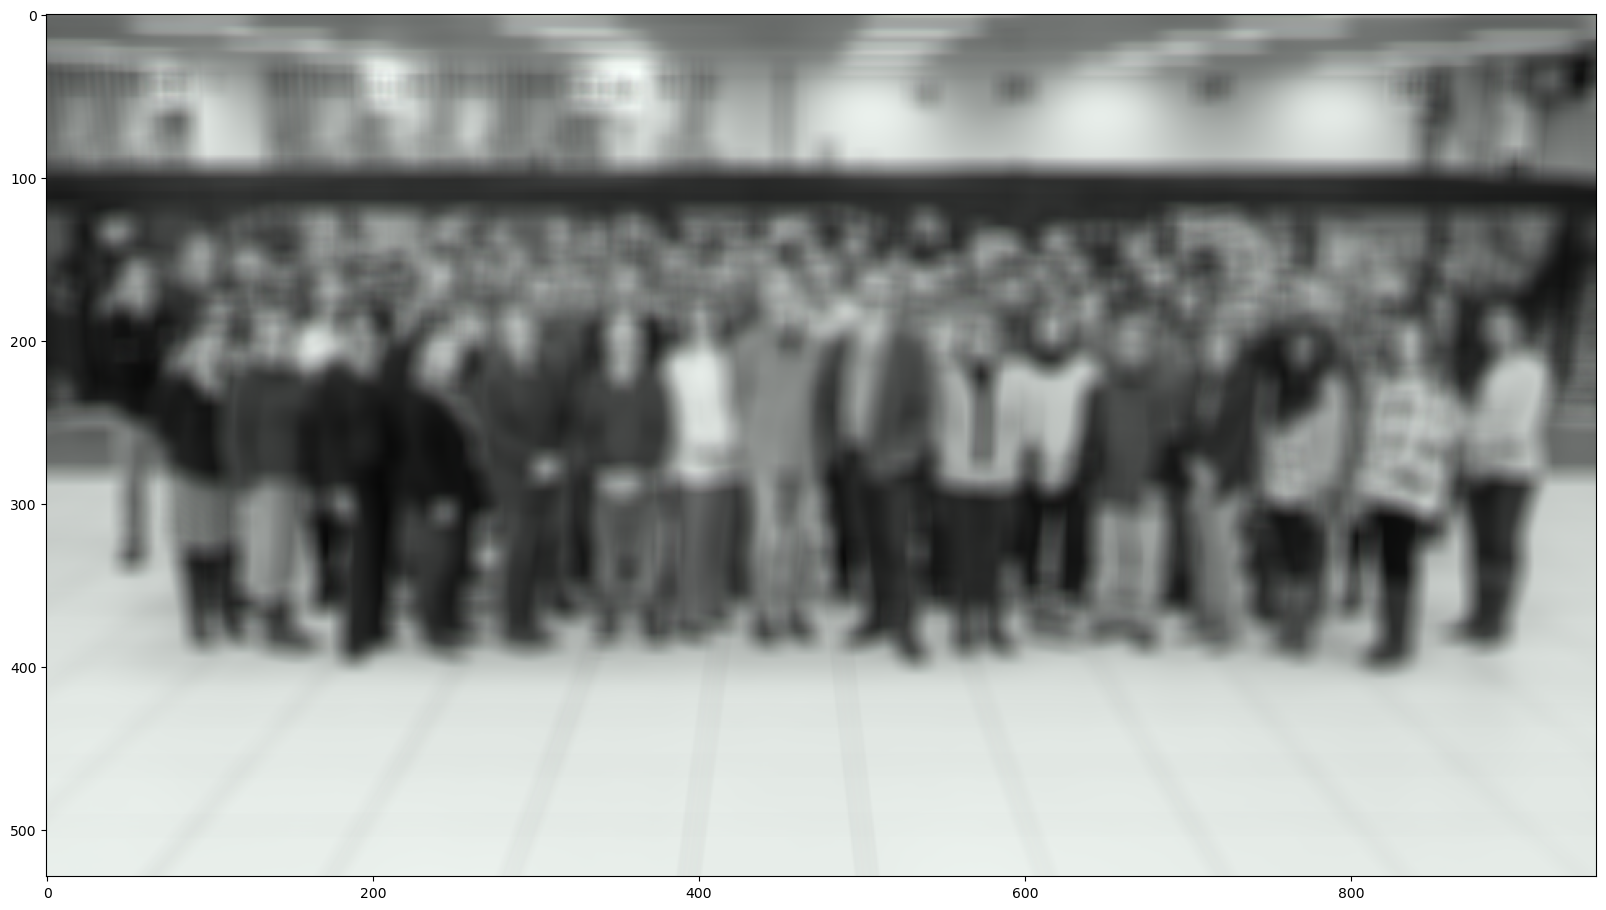

In [4]:
# Let's apply a convolution to the ALCF Staff photo:
alcf_tensor = torchvision.transforms.ToTensor()(alcf_image)

# Reshape the tensor to have a batch size of 1:
alcf_tensor = alcf_tensor.reshape((1,) + alcf_tensor.shape)

# Create a random convolution:
# shape is: (channels_in, channels_out, kernel_x, kernel_y)
conv_random = torch.rand((3,3,15,15))

alcf_rand = torch.nn.functional.conv2d(alcf_tensor, conv_random)
alcf_rand = (1./alcf_rand.max()) * alcf_rand
print(alcf_rand.shape)
alcf_rand = alcf_rand.reshape(alcf_rand.shape[1:])

print(alcf_tensor.shape)

rand_image = alcf_rand.permute((1,2,0)).cpu()

figure = plt.figure(figsize=(20,20))

plt.imshow(rand_image)


## Normalization

![Batch Norm](batch_norm.png)
Reference: [Normalizations](https://arxiv.org/pdf/1903.10520.pdf)

Normalization is the act of transforming the mean and moment of your data to standard values (usually 0.0 and 1.0).  It's particularly useful in machine learning since it stabilizes training, and allows higher learning rates.

![Batch Normalization accelerates training](batch_norm_effect.png)

Reference: [Batch Norm](https://arxiv.org/pdf/1502.03167.pdf)


torch.Size([1, 3, 543, 965])


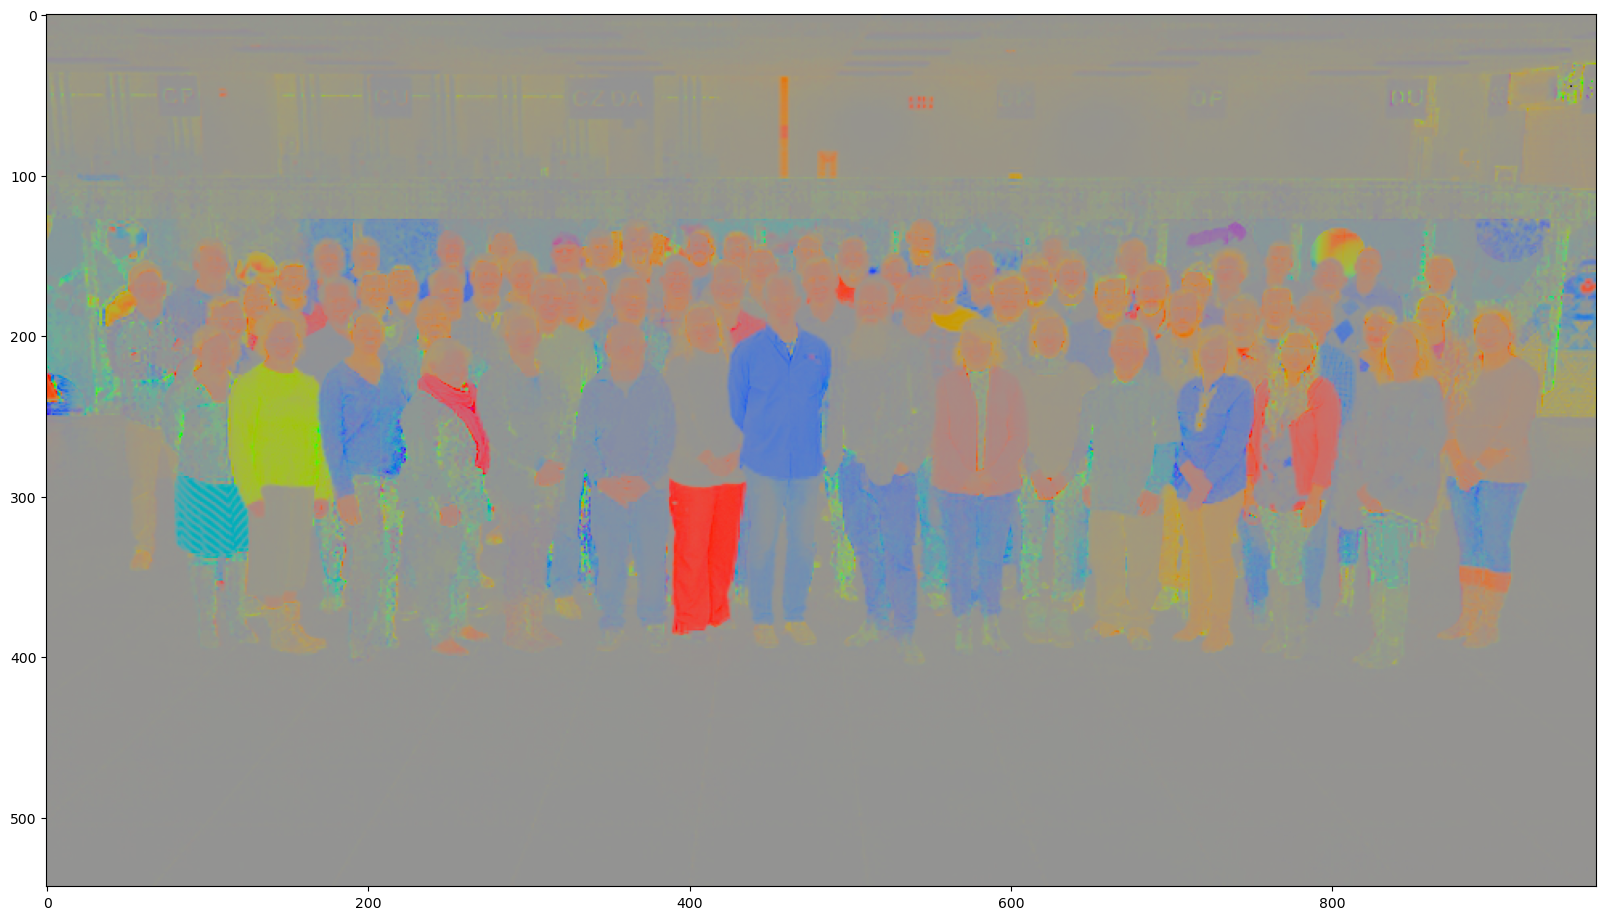

In [5]:
# Let's apply a normalization to the ALCF Staff photo:
alcf_tensor = torchvision.transforms.ToTensor()(alcf_image)

# Reshape the tensor to have a batch size of 1:
alcf_tensor = alcf_tensor.reshape((1,) + alcf_tensor.shape)


alcf_rand = torch.nn.functional.normalize(alcf_tensor)
alcf_rand = alcf_rand.reshape(alcf_rand.shape[1:])

print(alcf_tensor.shape)

rand_image = alcf_rand.permute((1,2,0)).cpu()

figure = plt.figure(figsize=(20,20))

plt.imshow(rand_image)



## Downsampling (And upsampling)

Downsampling is a critical component of convolutional and many vision models.  Because of the local-only nature of convolutional filters, learning large-range features can be too slow for convergence.  Downsampling of layers can bring information from far away closer, effectively changing what it means to be "local" as the input to a convolution.

![Convolutional Pooling](conv_pooling.png "Pooling")

[Reference](https://www.researchgate.net/publication/333593451_Application_of_Transfer_Learning_Using_Convolutional_Neural_Network_Method_for_Early_Detection_of_Terry's_Nail)



torch.Size([1, 3, 543, 965])


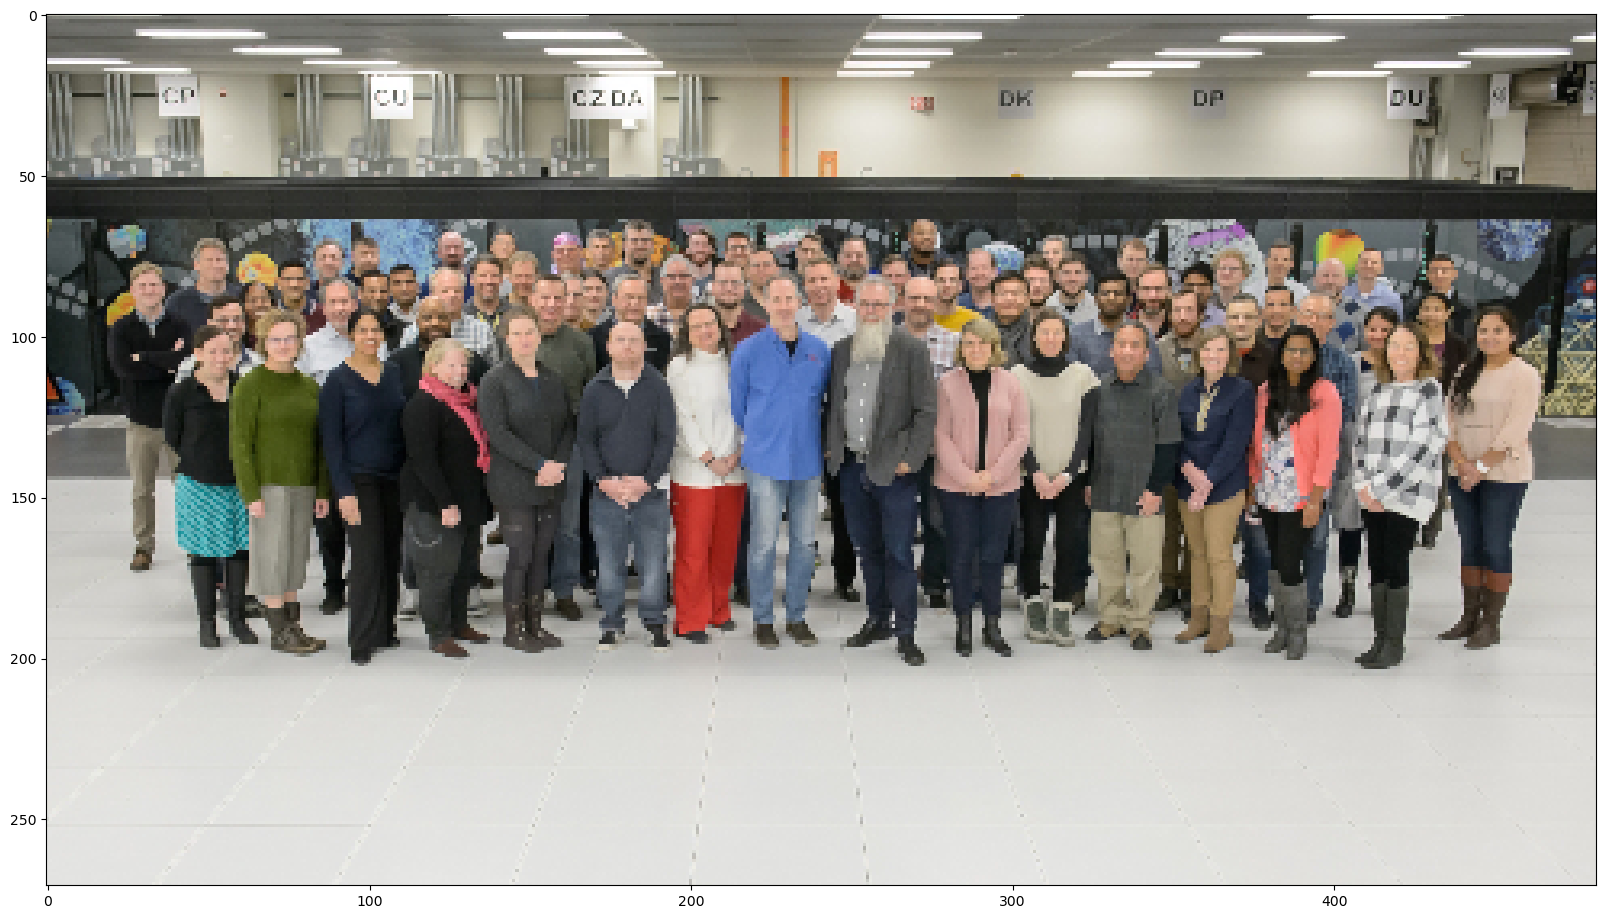

In [6]:
# Let's apply a normalization to the ALCF Staff photo:
alcf_tensor = torchvision.transforms.ToTensor()(alcf_image)

# Reshape the tensor to have a batch size of 1:
alcf_tensor = alcf_tensor.reshape((1,) + alcf_tensor.shape)


alcf_rand = torch.nn.functional.max_pool2d(alcf_tensor, 2)
alcf_rand = alcf_rand.reshape(alcf_rand.shape[1:])

print(alcf_tensor.shape)

rand_image = alcf_rand.permute((1,2,0)).cpu()

figure = plt.figure(figsize=(20,20))

plt.imshow(rand_image)


## Residual Connections

One issue, quickly encountered when making convolutional networks deeper and deeper, is the "Vanishing Gradients" problem.  As layers were stacked on top of each other, the size of updates dimished at the earlier layers of a convolutional network.  The paper "Deep Residual Learning for Image Recognition" solved this by introduction "residual connections" as skip layers.


Reference: [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)

![Residual Layer](residual_layer.png)


Compare the performance of the models before and after the introduction of these layers:

![Resnet Performance vs. Plain network performance](resnet_comparison.png)

If you have time to read only one paper on computer vision, make it this one!  Resnet was the first model to beat human accuracy on ImageNet and is one of the most impactful papers in AI ever published.

# Building a ConvNet

In this section we'll build and apply a conv net to the mnist dataset.  The layers here are loosely based off of the ConvNext architecture.  Why?  Because we're getting into LLM's soon, and this ConvNet uses LLM features.  ConvNext is an update to the ResNet architecture that outperforms it.

[ConvNext](https://arxiv.org/abs/2201.03545)


The dataset here is CIFAR-10 - slightly harder than MNIST but still relatively easy and computationally tractable.

In [7]:
from torchvision.transforms import v2
training_data = torchvision.datasets.CIFAR10(
    # Polaris: root="/lus/eagle/projects/datasets/CIFAR-10/",
    # Polaris: download=False,
    root="data",
    download=True,
    train=True,
    transform=v2.Compose([
        v2.ToTensor(),
        v2.RandomHorizontalFlip(),
        v2.RandomResizedCrop(size=32, scale=[0.85,1.0], antialias=False),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    ])
)

test_data = torchvision.datasets.CIFAR10(
    # Polaris: root="/lus/eagle/projects/datasets/CIFAR-10/",
    # Polaris: download=False,
    root="data",
    download=True,
    train=False,
    transform=torchvision.transforms.ToTensor()
)

training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))

batch_size = 128

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, 
    batch_size=batch_size, 
    pin_memory=True,
    shuffle=True, 
    num_workers=2)
val_dataloader = torch.utils.data.DataLoader(validation_data, 
    batch_size=batch_size, 
    pin_memory=True,
    shuffle=False, 
    num_workers=2)

c:\Users\armin\anaconda3\envs\torch\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

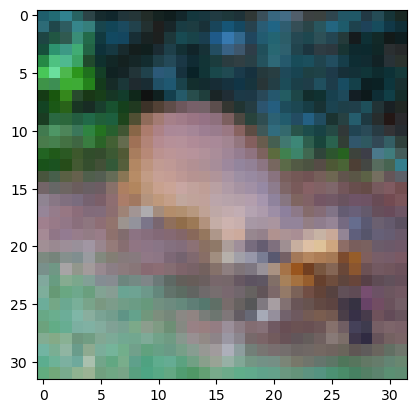

In [9]:
batch, (X, Y) = next(enumerate(train_dataloader))
plt.imshow(X[0].cpu().permute((1,2,0))); plt.show()

This code below is important as our models get bigger: this is wrapping the pytorch data loaders to put the data onto the GPU!

In [10]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")


def preprocess(x, y):
    # CIFAR-10 is *color* images so 3 layers!
    return x.view(-1, 3, 32, 32).to(dev), y.to(dev)


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))


train_dataloader = WrappedDataLoader(train_dataloader, preprocess)
val_dataloader = WrappedDataLoader(val_dataloader, preprocess)

In [11]:
from torch import nn


class Downsampler(nn.Module):

    def __init__(self, in_channels, out_channels, shape, stride=2):
        super(Downsampler, self).__init__()

        self.norm = nn.LayerNorm([in_channels, *shape])

        self.downsample = nn.Conv2d(
            in_channels=in_channels, 
            out_channels=out_channels,
            kernel_size = stride,
            stride = stride,
        )
    
    def forward(self, inputs):


        return self.downsample(self.norm(inputs))
        
        

class ConvNextBlock(nn.Module):
    """This block of operations is loosely based on this paper:

    """


    def __init__(self, in_channels, shape):
        super(ConvNextBlock, self).__init__()

        # Depthwise, seperable convolution with a large number of output filters:
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=in_channels, 
                                     groups=in_channels,
                                     kernel_size=[7,7],
                                     padding='same' )

        self.norm = nn.LayerNorm([in_channels, *shape])

        # Two more convolutions:
        self.conv2 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=4*in_channels,
                                     kernel_size=1)

        self.conv3 = nn.Conv2d(in_channels=4*in_channels, 
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )


    def forward(self, inputs):
        x = self.conv1(inputs)

        # The normalization layer:
        x = self.norm(x)

        x = self.conv2(x)

        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        x = self.conv3(x)

        # This makes it a residual network:
        return x + inputs
    

class Classifier(nn.Module):


    def __init__(self, n_initial_filters, n_stages, blocks_per_stage):
        super(Classifier, self).__init__()

        # This is a downsampling convolution that will produce patches of output.

        # This is similar to what vision transformers do to tokenize the images.
        self.stem = nn.Conv2d(in_channels=3,
                                    out_channels=n_initial_filters,
                                    kernel_size=1,
                                    stride=1)
        
        current_shape = [32, 32]

        self.norm1 = nn.LayerNorm([n_initial_filters,*current_shape])
        # self.norm1 = WrappedLayerNorm()

        current_n_filters = n_initial_filters
        
        self.layers = nn.Sequential()
        for i, n_blocks in enumerate(range(n_stages)):
            # Add a convnext block series:
            for _ in range(blocks_per_stage):
                self.layers.append(ConvNextBlock(in_channels=current_n_filters, shape=current_shape))
            # Add a downsampling layer:
            if i != n_stages - 1:
                # Skip downsampling if it's the last layer!
                self.layers.append(Downsampler(
                    in_channels=current_n_filters, 
                    out_channels=2*current_n_filters,
                    shape = current_shape,
                    )
                )
                # Double the number of filters:
                current_n_filters = 2*current_n_filters
                # Cut the shape in half:
                current_shape = [ cs // 2 for cs in current_shape]
            


        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(current_n_filters),
            nn.Linear(current_n_filters, 10)
        )
        # self.norm2 = nn.InstanceNorm2d(current_n_filters)
        # # This brings it down to one channel / class
        # self.bottleneck = nn.Conv2d(in_channels=current_n_filters, out_channels=10, 
        #                                   kernel_size=1, stride=1)

    def forward(self, inputs):

        x = self.stem(inputs)
        # Apply a normalization after the initial patching:
        x = self.norm1(x)

        # Apply the main chunk of the network:
        x = self.layers(x)

        # Normalize and readout:
        x = nn.functional.avg_pool2d(x, x.shape[2:])
        x = self.head(x)

        return x



        # x = self.norm2(x)
        # x = self.bottleneck(x)

        # # Average pooling of the remaining spatial dimensions (and reshape) makes this label-like:
        # return nn.functional.avg_pool2d(x, kernel_size=x.shape[-2:]).reshape((-1,10))

In [12]:
#! pip install torchinfo # if not on Polaris

In [13]:
model = Classifier(32, 4, 2).to(device=dev)

from torchinfo import summary

print(summary(model, input_size=(batch_size, 3, 32, 32)))


Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [128, 10]                 --
├─Conv2d: 1-1                            [128, 32, 32, 32]         128
├─LayerNorm: 1-2                         [128, 32, 32, 32]         65,536
├─Sequential: 1-3                        [128, 256, 4, 4]          --
│    └─ConvNextBlock: 2-1                [128, 32, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 32, 32, 32]         1,600
│    │    └─LayerNorm: 3-2               [128, 32, 32, 32]         65,536
│    │    └─Conv2d: 3-3                  [128, 128, 32, 32]        4,224
│    │    └─Conv2d: 3-4                  [128, 32, 32, 32]         4,128
│    └─ConvNextBlock: 2-2                [128, 32, 32, 32]         --
│    │    └─Conv2d: 3-5                  [128, 32, 32, 32]         1,600
│    │    └─LayerNorm: 3-6               [128, 32, 32, 32]         65,536
│    │    └─Conv2d: 3-7                  [128, 128, 32, 32] 

In [14]:
def evaluate(dataloader, model, loss_fn, val_bar):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing 
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:

            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            val_bar.update()
            
    loss /= num_batches
    correct /= (size*batch_size)
    
    accuracy = 100*correct
    return accuracy, loss

In [15]:
def train_one_epoch(dataloader, model, loss_fn, optimizer, progress_bar):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()      

        progress_bar.update()

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.01)

In [17]:
from tqdm.notebook import tqdm


epochs = 0
for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar)
    
    # checking on the training & validation loss & accuracy 
    # for training data - only once every 5 epochs (takes a while) 
    if j % 5 == 0:
        with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
            acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval)
            print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
            
    with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:
    
        acc_val, loss_val = evaluate(val_dataloader, model, loss_fn, val_bar)
        print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")
    

# Homework 1:

In this notebook, we've learned about some basic convolutional networks and trained one on CIFAR-10 images.  It did ... OK.  There is significant overfitting of this model.  There are some ways to address that, but we didn't have time to get into that in this session.

Meanwhile, your homework (part 1) for this week is to try to train the model again but with a different architecture.  Change one or more of the following:
- The number of convolutions between downsampling
- The number of filters in each layer
- The initial "patchify" layer
- Another hyper-parameter of your choosing


And compare your final validation accuracy to the accuracy shown here.  Can you beat the validation accuracy shown?

For full credit on the homework, you need to show (via text, or make a plot) the training and validation data sets' performance (loss and accuracy) for all the epochs you train.  You also need to explain, in several sentences, what you changed in the network and why you think it makes a difference.

In [18]:
def train_one_epoch(dataloader, model, loss_fn, optimizer, progress_bar):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()      

        progress_bar.update()

In [19]:
def train_model(model, loss_fn, optimizer, scheduler, epochs, train_dl, val_dl):
    t_epochs = []
    accs_t = []
    losses_t = []
    accs_v = []
    losses_v = []
    for j in range(epochs):
        with tqdm(total=len(train_dl), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
            train_one_epoch(train_dl, model, loss_fn, optimizer, train_bar)
        
        # checking on the training & validation loss & accuracy 
        # for training data - only once every 5 epochs (takes a while) 
        if j % 5 == 0:
            with tqdm(total=len(train_dl), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
                acc, loss = evaluate(train_dl, model, loss_fn, train_eval)
                t_epochs.append(j)
                accs_t.append(acc)
                losses_t.append(loss)
                print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
                
        with tqdm(total=len(val_dl), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:
        
            acc_val, loss_val = evaluate(val_dl, model, loss_fn, val_bar)
            accs_v.append(acc_val)
            losses_v.append(loss_val)
            print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")
        scheduler.step()
    return {"train_epochs": t_epochs, "train_accs": accs_t, "train_losses": losses_t, "val_accs": accs_v, "val_losses": losses_v}

In [20]:
def plot_res(res):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi=150)
    ax[0].plot(res['train_epochs'], res['train_accs'], label="Training")
    ax[0].plot(range(len(res['val_accs'])), res['val_accs'], label="Validation")
    ax[0].set_title("Accuracy")
    ax[1].plot(res['train_epochs'], res['train_losses'], label="Training")
    ax[1].plot(range(len(res['val_losses'])), res['val_losses'], label="Validation")
    ax[1].set_title("Loss")
    plt.legend()
    plt.show()
    return ax

# Fewer convolutions between downsampling

In [30]:
model_1 = Classifier(32, 4, 1).to(device=dev)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.005, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, gamma=0.5)

In [31]:
res_1 = train_model(model_1, loss_fn, optimizer, scheduler, 50, train_dataloader, val_dataloader)

Train Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: training loss: 2.008, accuracy: 26.857


Validate Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0: validation loss: 2.014, accuracy: 26.256


Train Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1: validation loss: 1.899, accuracy: 30.360


Train Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2: validation loss: 1.762, accuracy: 35.878


Train Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3: validation loss: 1.726, accuracy: 36.195


Train Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4: validation loss: 1.766, accuracy: 33.703


Train Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: training loss: 1.607, accuracy: 42.173


Validate Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: validation loss: 1.607, accuracy: 42.049


Train Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6: validation loss: 1.599, accuracy: 42.623


Train Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7: validation loss: 1.613, accuracy: 41.466


Train Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8: validation loss: 1.594, accuracy: 42.168


Train Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9: validation loss: 1.556, accuracy: 43.463


Train Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: training loss: 1.496, accuracy: 46.368


Validate Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10: validation loss: 1.493, accuracy: 46.015


Train Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11: validation loss: 1.494, accuracy: 45.975


Train Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12: validation loss: 1.507, accuracy: 45.352


Train Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13: validation loss: 1.488, accuracy: 46.034


Train Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14: validation loss: 1.467, accuracy: 46.756


Train Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15: training loss: 1.448, accuracy: 48.178


Validate Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15: validation loss: 1.453, accuracy: 47.567


Train Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16: validation loss: 1.443, accuracy: 47.854


Train Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17: validation loss: 1.435, accuracy: 47.894


Train Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18: validation loss: 1.447, accuracy: 47.399


Train Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19: validation loss: 1.434, accuracy: 47.419


Train Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20: training loss: 1.414, accuracy: 49.226


Validate Epoch 20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20: validation loss: 1.423, accuracy: 48.576


Train Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 21:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21: validation loss: 1.412, accuracy: 49.357


Train Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 22:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22: validation loss: 1.406, accuracy: 49.258


Train Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 23:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23: validation loss: 1.417, accuracy: 49.466


Train Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 24:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24: validation loss: 1.398, accuracy: 49.713


Train Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 25: training loss: 1.391, accuracy: 50.035


Validate Epoch 25:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25: validation loss: 1.400, accuracy: 49.911


Train Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 26:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26: validation loss: 1.394, accuracy: 49.555


Train Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 27:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27: validation loss: 1.399, accuracy: 49.644


Train Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 28:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28: validation loss: 1.399, accuracy: 49.515


Train Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 29:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29: validation loss: 1.407, accuracy: 49.021


Train Epoch 30:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 30:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 30: training loss: 1.382, accuracy: 50.344


Validate Epoch 30:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 30: validation loss: 1.394, accuracy: 49.921


Train Epoch 31:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 31:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 31: validation loss: 1.393, accuracy: 49.911


Train Epoch 32:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 32:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 32: validation loss: 1.388, accuracy: 49.862


Train Epoch 33:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 33:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 33: validation loss: 1.385, accuracy: 49.891


Train Epoch 34:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 34:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 34: validation loss: 1.393, accuracy: 49.773


Train Epoch 35:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 35: training loss: 1.381, accuracy: 50.691


Validate Epoch 35:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 35: validation loss: 1.391, accuracy: 49.268


Train Epoch 36:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 36:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 36: validation loss: 1.390, accuracy: 49.555


Train Epoch 37:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 37:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 37: validation loss: 1.381, accuracy: 50.237


Train Epoch 38:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 38:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 38: validation loss: 1.388, accuracy: 49.693


Train Epoch 39:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 39:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 39: validation loss: 1.386, accuracy: 49.466


Train Epoch 40:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 40: training loss: 1.377, accuracy: 50.691


Validate Epoch 40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 40: validation loss: 1.384, accuracy: 50.326


Train Epoch 41:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 41:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 41: validation loss: 1.389, accuracy: 50.267


Train Epoch 42:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 42:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 42: validation loss: 1.387, accuracy: 50.405


Train Epoch 43:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 43:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 43: validation loss: 1.384, accuracy: 50.168


Train Epoch 44:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 44:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 44: validation loss: 1.382, accuracy: 49.812


Train Epoch 45:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 45:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 45: training loss: 1.378, accuracy: 50.706


Validate Epoch 45:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 45: validation loss: 1.381, accuracy: 50.119


Train Epoch 46:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 46:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 46: validation loss: 1.383, accuracy: 50.059


Train Epoch 47:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 47:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 47: validation loss: 1.385, accuracy: 50.089


Train Epoch 48:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 48:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 48: validation loss: 1.385, accuracy: 50.425


Train Epoch 49:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 49:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 49: validation loss: 1.386, accuracy: 49.980


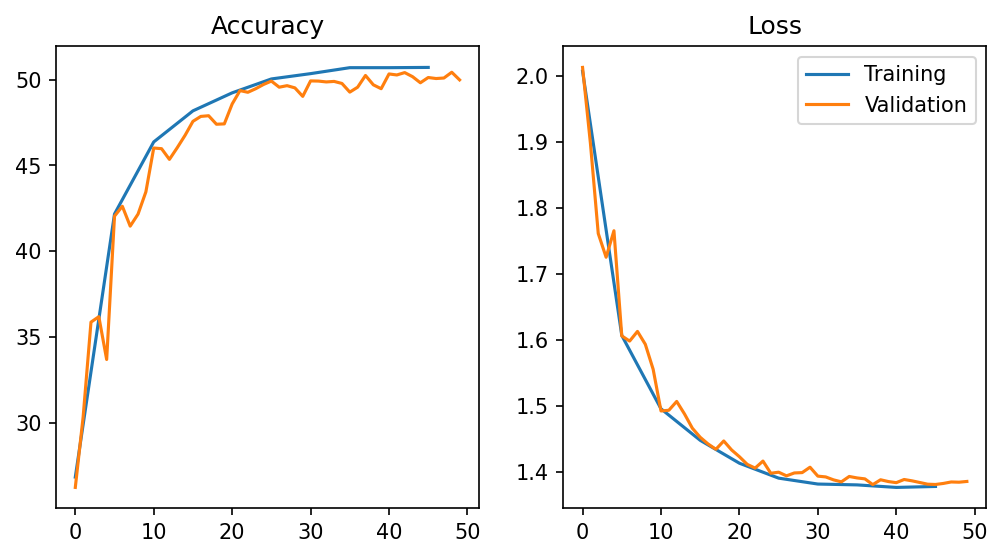

array([<Axes: title={'center': 'Accuracy'}>,
       <Axes: title={'center': 'Loss'}>], dtype=object)

In [32]:
plot_res(res_1)

# More convolutions between downsampling

In [21]:
model_2 = Classifier(32, 4, 3).to(device=dev)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.01, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, gamma=0.5)

In [22]:
res_2 = train_model(model_2, loss_fn, optimizer, scheduler, 50, train_dataloader, val_dataloader)

Train Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: training loss: 1.930, accuracy: 27.568


Validate Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0: validation loss: 1.929, accuracy: 26.701


Train Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1: validation loss: 1.722, accuracy: 37.559


Train Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2: validation loss: 1.636, accuracy: 40.576


Train Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3: validation loss: 1.535, accuracy: 43.542


Train Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4: validation loss: 1.576, accuracy: 41.110


Train Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: training loss: 1.453, accuracy: 47.329


Validate Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: validation loss: 1.450, accuracy: 47.182


Train Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6: validation loss: 1.443, accuracy: 48.032


Train Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7: validation loss: 1.466, accuracy: 46.954


Train Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8: validation loss: 1.388, accuracy: 49.367


Train Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9: validation loss: 1.372, accuracy: 50.682


Train Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: training loss: 1.327, accuracy: 52.653


Validate Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10: validation loss: 1.331, accuracy: 52.126


Train Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11: validation loss: 1.358, accuracy: 50.257


Train Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12: validation loss: 1.345, accuracy: 51.206


Train Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13: validation loss: 1.314, accuracy: 52.799


Train Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14: validation loss: 1.324, accuracy: 52.294


Train Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15: training loss: 1.278, accuracy: 54.595


Validate Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15: validation loss: 1.292, accuracy: 53.560


Train Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16: validation loss: 1.271, accuracy: 54.282


Train Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17: validation loss: 1.273, accuracy: 54.183


Train Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18: validation loss: 1.304, accuracy: 52.967


Train Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19: validation loss: 1.284, accuracy: 53.066


Train Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20: training loss: 1.245, accuracy: 55.551


Validate Epoch 20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20: validation loss: 1.261, accuracy: 54.341


Train Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 21:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21: validation loss: 1.257, accuracy: 54.826


Train Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 22:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22: validation loss: 1.252, accuracy: 54.856


Train Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 23:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23: validation loss: 1.251, accuracy: 54.114


Train Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 24:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24: validation loss: 1.243, accuracy: 54.806


Train Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 25: training loss: 1.219, accuracy: 56.782


Validate Epoch 25:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25: validation loss: 1.232, accuracy: 55.825


Train Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 26:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26: validation loss: 1.241, accuracy: 55.419


Train Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 27:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27: validation loss: 1.232, accuracy: 55.815


Train Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 28:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28: validation loss: 1.237, accuracy: 55.459


Train Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 29:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29: validation loss: 1.233, accuracy: 55.835


Train Epoch 30:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 30:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 30: training loss: 1.210, accuracy: 57.181


Validate Epoch 30:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 30: validation loss: 1.224, accuracy: 56.319


Train Epoch 31:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 31:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 31: validation loss: 1.229, accuracy: 55.400


Train Epoch 32:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 32:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 32: validation loss: 1.235, accuracy: 55.617


Train Epoch 33:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 33:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 33: validation loss: 1.236, accuracy: 55.212


Train Epoch 34:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 34:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 34: validation loss: 1.225, accuracy: 55.340


Train Epoch 35:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 35: training loss: 1.205, accuracy: 57.338


Validate Epoch 35:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 35: validation loss: 1.224, accuracy: 55.765


Train Epoch 36:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 36:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 36: validation loss: 1.229, accuracy: 55.845


Train Epoch 37:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 37:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 37: validation loss: 1.222, accuracy: 56.260


Train Epoch 38:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 38:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 38: validation loss: 1.227, accuracy: 56.230


Train Epoch 39:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 39:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 39: validation loss: 1.225, accuracy: 56.131


Train Epoch 40:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 40: training loss: 1.202, accuracy: 57.528


Validate Epoch 40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 40: validation loss: 1.220, accuracy: 56.359


Train Epoch 41:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 41:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 41: validation loss: 1.221, accuracy: 55.686


Train Epoch 42:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 42:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 42: validation loss: 1.219, accuracy: 56.102


Train Epoch 43:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 43:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 43: validation loss: 1.217, accuracy: 56.201


Train Epoch 44:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 44:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 44: validation loss: 1.216, accuracy: 56.151


Train Epoch 45:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 45:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 45: training loss: 1.200, accuracy: 57.635


Validate Epoch 45:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 45: validation loss: 1.228, accuracy: 55.775


Train Epoch 46:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 46:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 46: validation loss: 1.219, accuracy: 55.815


Train Epoch 47:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 47:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 47: validation loss: 1.225, accuracy: 55.874


Train Epoch 48:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 48:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 48: validation loss: 1.225, accuracy: 55.400


Train Epoch 49:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 49:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 49: validation loss: 1.218, accuracy: 55.934


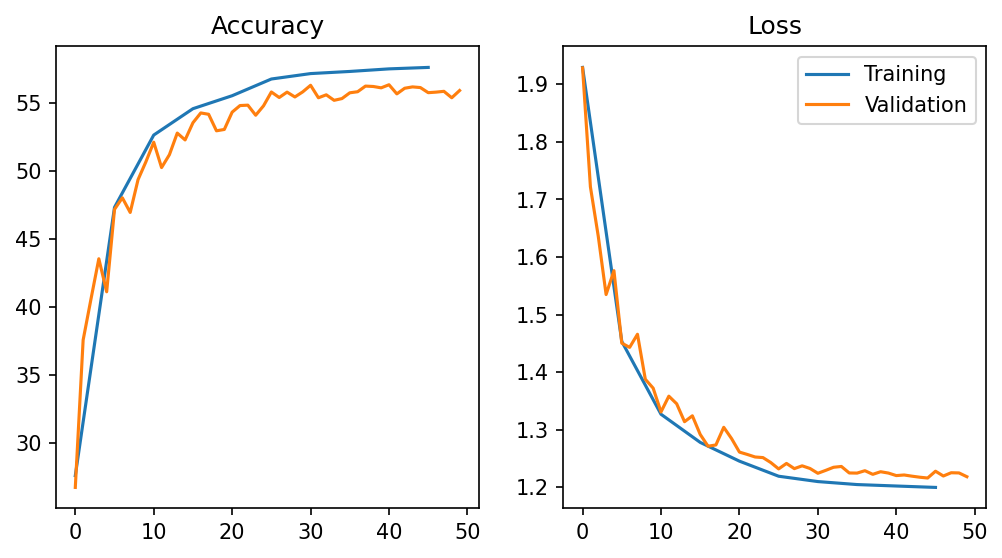

array([<Axes: title={'center': 'Accuracy'}>,
       <Axes: title={'center': 'Loss'}>], dtype=object)

In [23]:
plot_res(res_2)

# Fewer blocks

In [24]:
model_3 = Classifier(32, 2, 2).to(device=dev)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.01, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, gamma=0.5)

In [25]:
res_3 = train_model(model_3, loss_fn, optimizer, scheduler, 50, train_dataloader, val_dataloader)

Train Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: training loss: 2.184, accuracy: 16.394


Validate Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0: validation loss: 2.185, accuracy: 16.278


Train Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1: validation loss: 2.064, accuracy: 22.973


Train Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2: validation loss: 1.955, accuracy: 27.294


Train Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3: validation loss: 1.961, accuracy: 26.533


Train Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4: validation loss: 1.934, accuracy: 29.727


Train Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: training loss: 1.800, accuracy: 34.452


Validate Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: validation loss: 1.800, accuracy: 34.138


Train Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6: validation loss: 1.824, accuracy: 30.963


Train Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7: validation loss: 1.803, accuracy: 32.358


Train Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8: validation loss: 1.723, accuracy: 37.164


Train Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9: validation loss: 1.717, accuracy: 36.264


Train Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: training loss: 1.651, accuracy: 40.243


Validate Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10: validation loss: 1.645, accuracy: 40.081


Train Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11: validation loss: 1.678, accuracy: 37.965


Train Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12: validation loss: 1.640, accuracy: 39.597


Train Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13: validation loss: 1.681, accuracy: 39.053


Train Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14: validation loss: 1.590, accuracy: 41.802


Train Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15: training loss: 1.579, accuracy: 42.866


Validate Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15: validation loss: 1.569, accuracy: 42.959


Train Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16: validation loss: 1.584, accuracy: 42.563


Train Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17: validation loss: 1.568, accuracy: 43.394


Train Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18: validation loss: 1.579, accuracy: 42.781


Train Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19: validation loss: 1.543, accuracy: 44.393


Train Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20: training loss: 1.544, accuracy: 44.816


Validate Epoch 20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20: validation loss: 1.537, accuracy: 44.472


Train Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 21:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21: validation loss: 1.537, accuracy: 44.017


Train Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 22:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22: validation loss: 1.556, accuracy: 44.333


Train Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 23:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23: validation loss: 1.522, accuracy: 45.293


Train Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 24:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24: validation loss: 1.526, accuracy: 45.441


Train Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 25: training loss: 1.514, accuracy: 45.372


Validate Epoch 25:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25: validation loss: 1.508, accuracy: 45.856


Train Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 26:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26: validation loss: 1.523, accuracy: 44.947


Train Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 27:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27: validation loss: 1.496, accuracy: 45.748


Train Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 28:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28: validation loss: 1.497, accuracy: 46.361


Train Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 29:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29: validation loss: 1.498, accuracy: 45.599


Train Epoch 30:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 30:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 30: training loss: 1.492, accuracy: 46.508


Validate Epoch 30:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 30: validation loss: 1.491, accuracy: 46.242


Train Epoch 31:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 31:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 31: validation loss: 1.491, accuracy: 46.282


Train Epoch 32:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 32:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 32: validation loss: 1.485, accuracy: 46.746


Train Epoch 33:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 33:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 33: validation loss: 1.490, accuracy: 46.489


Train Epoch 34:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 34:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 34: validation loss: 1.487, accuracy: 46.371


Train Epoch 35:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 35: training loss: 1.486, accuracy: 46.997


Validate Epoch 35:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 35: validation loss: 1.484, accuracy: 46.628


Train Epoch 36:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 36:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 36: validation loss: 1.480, accuracy: 47.261


Train Epoch 37:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 37:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 37: validation loss: 1.480, accuracy: 47.360


Train Epoch 38:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 38:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 38: validation loss: 1.476, accuracy: 46.717


Train Epoch 39:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 39:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 39: validation loss: 1.477, accuracy: 46.746


Train Epoch 40:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 40: training loss: 1.479, accuracy: 47.419


Validate Epoch 40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 40: validation loss: 1.472, accuracy: 47.241


Train Epoch 41:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 41:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 41: validation loss: 1.472, accuracy: 47.093


Train Epoch 42:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 42:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 42: validation loss: 1.473, accuracy: 47.597


Train Epoch 43:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 43:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 43: validation loss: 1.470, accuracy: 47.567


Train Epoch 44:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 44:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 44: validation loss: 1.469, accuracy: 47.083


Train Epoch 45:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 45:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 45: training loss: 1.477, accuracy: 47.214


Validate Epoch 45:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 45: validation loss: 1.468, accuracy: 47.330


Train Epoch 46:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 46:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 46: validation loss: 1.472, accuracy: 46.855


Train Epoch 47:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 47:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 47: validation loss: 1.470, accuracy: 47.280


Train Epoch 48:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 48:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 48: validation loss: 1.471, accuracy: 47.508


Train Epoch 49:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 49:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 49: validation loss: 1.474, accuracy: 46.994


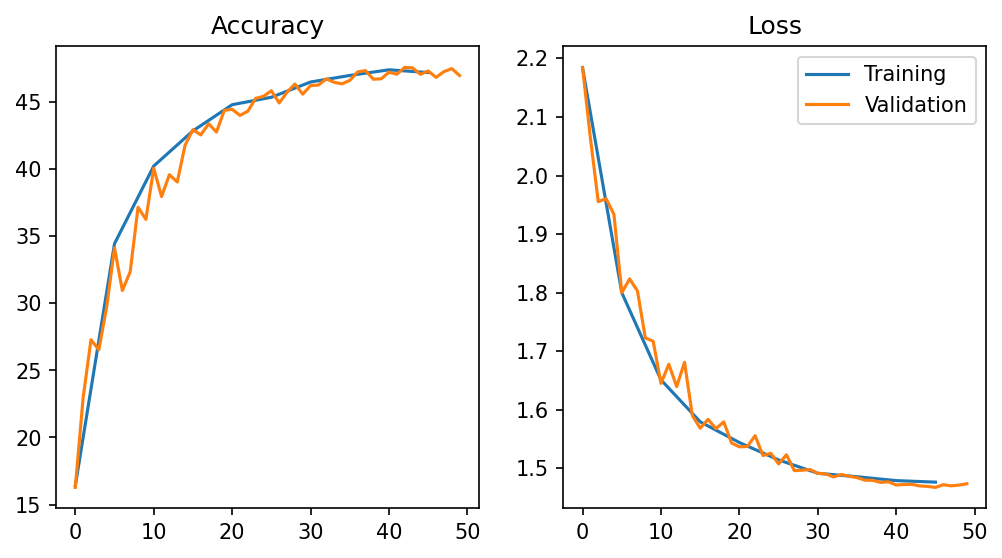

array([<Axes: title={'center': 'Accuracy'}>,
       <Axes: title={'center': 'Loss'}>], dtype=object)

In [26]:
plot_res(res_3)

# More blocks

In [27]:
model_4 = Classifier(32, 6, 2).to(device=dev)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.01, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, gamma=0.5)

In [28]:
res_4 = train_model(model_4, loss_fn, optimizer, scheduler, 50, train_dataloader, val_dataloader)

Train Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: training loss: 1.830, accuracy: 33.369


Validate Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0: validation loss: 1.837, accuracy: 33.060


Train Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1: validation loss: 1.570, accuracy: 43.335


Train Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2: validation loss: 1.473, accuracy: 46.430


Train Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3: validation loss: 1.519, accuracy: 45.065


Train Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4: validation loss: 1.448, accuracy: 47.567


Train Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: training loss: 1.297, accuracy: 53.924


Validate Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: validation loss: 1.325, accuracy: 52.087


Train Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6: validation loss: 1.283, accuracy: 53.748


Train Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7: validation loss: 1.283, accuracy: 53.728


Train Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8: validation loss: 1.278, accuracy: 53.768


Train Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9: validation loss: 1.274, accuracy: 53.975


Train Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: training loss: 1.158, accuracy: 59.115


Validate Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10: validation loss: 1.197, accuracy: 57.031


Train Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11: validation loss: 1.217, accuracy: 56.260


Train Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12: validation loss: 1.189, accuracy: 57.565


Train Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13: validation loss: 1.207, accuracy: 57.091


Train Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14: validation loss: 1.171, accuracy: 58.356


Train Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15: training loss: 1.109, accuracy: 61.062


Validate Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15: validation loss: 1.167, accuracy: 58.297


Train Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16: validation loss: 1.159, accuracy: 58.821


Train Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17: validation loss: 1.151, accuracy: 58.841


Train Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18: validation loss: 1.146, accuracy: 58.841


Train Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19: validation loss: 1.140, accuracy: 59.019


Train Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20: training loss: 1.070, accuracy: 62.295


Validate Epoch 20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20: validation loss: 1.131, accuracy: 59.850


Train Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 21:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21: validation loss: 1.128, accuracy: 59.573


Train Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 22:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22: validation loss: 1.137, accuracy: 59.365


Train Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 23:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23: validation loss: 1.127, accuracy: 59.157


Train Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 24:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24: validation loss: 1.117, accuracy: 59.761


Train Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 25: training loss: 1.052, accuracy: 63.194


Validate Epoch 25:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25: validation loss: 1.115, accuracy: 60.067


Train Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 26:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26: validation loss: 1.112, accuracy: 60.443


Train Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 27:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27: validation loss: 1.107, accuracy: 60.107


Train Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 28:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28: validation loss: 1.112, accuracy: 59.771


Train Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 29:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29: validation loss: 1.112, accuracy: 60.206


Train Epoch 30:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 30:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 30: training loss: 1.041, accuracy: 63.693


Validate Epoch 30:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 30: validation loss: 1.105, accuracy: 60.502


Train Epoch 31:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 31:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 31: validation loss: 1.107, accuracy: 60.463


Train Epoch 32:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 32:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 32: validation loss: 1.100, accuracy: 60.700


Train Epoch 33:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 33:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 33: validation loss: 1.106, accuracy: 60.374


Train Epoch 34:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 34:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 34: validation loss: 1.096, accuracy: 60.651


Train Epoch 35:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 35: training loss: 1.040, accuracy: 63.558


Validate Epoch 35:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 35: validation loss: 1.102, accuracy: 60.522


Train Epoch 36:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 36:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 36: validation loss: 1.097, accuracy: 60.680


Train Epoch 37:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 37:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 37: validation loss: 1.100, accuracy: 60.354


Train Epoch 38:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 38:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 38: validation loss: 1.099, accuracy: 60.651


Train Epoch 39:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 39:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 39: validation loss: 1.102, accuracy: 60.057


Train Epoch 40:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 40: training loss: 1.033, accuracy: 63.918


Validate Epoch 40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 40: validation loss: 1.102, accuracy: 60.413


Train Epoch 41:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 41:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 41: validation loss: 1.101, accuracy: 60.611


Train Epoch 42:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 42:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 42: validation loss: 1.093, accuracy: 60.789


Train Epoch 43:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 43:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 43: validation loss: 1.094, accuracy: 61.165


Train Epoch 44:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 44:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 44: validation loss: 1.100, accuracy: 60.997


Train Epoch 45:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 45:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 45: training loss: 1.032, accuracy: 63.853


Validate Epoch 45:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 45: validation loss: 1.102, accuracy: 60.502


Train Epoch 46:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 46:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 46: validation loss: 1.101, accuracy: 60.344


Train Epoch 47:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 47:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 47: validation loss: 1.101, accuracy: 60.334


Train Epoch 48:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 48:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 48: validation loss: 1.095, accuracy: 60.572


Train Epoch 49:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 49:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 49: validation loss: 1.097, accuracy: 60.898


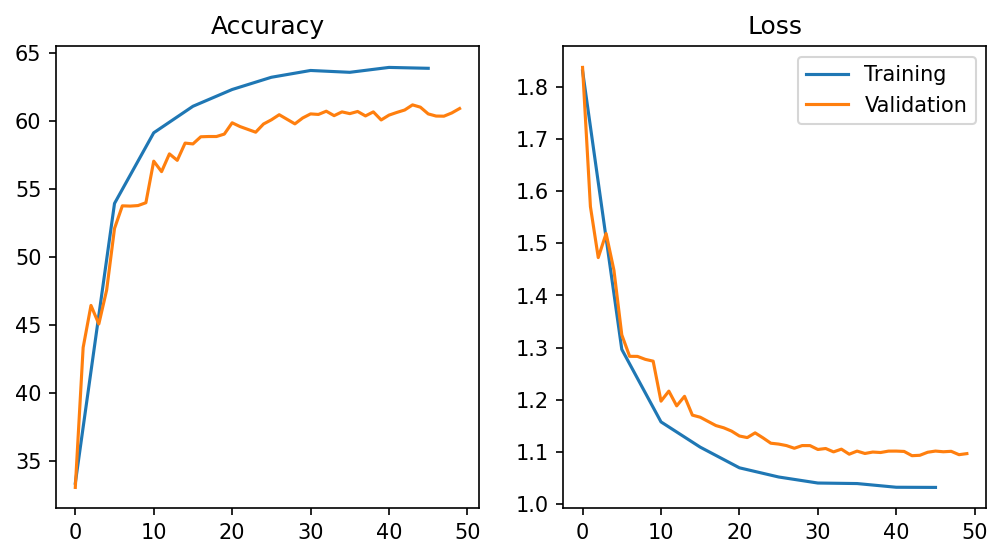

array([<Axes: title={'center': 'Accuracy'}>,
       <Axes: title={'center': 'Loss'}>], dtype=object)

In [29]:
plot_res(res_4)

# Fewer filters

In [30]:
model_5 = Classifier(16, 4, 2).to(device=dev)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_5.parameters(), lr=0.01, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, gamma=0.5)

In [31]:
res_5 = train_model(model_5, loss_fn, optimizer, scheduler, 50, train_dataloader, val_dataloader)

Train Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: training loss: 2.065, accuracy: 24.299


Validate Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0: validation loss: 2.059, accuracy: 24.357


Train Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1: validation loss: 1.865, accuracy: 32.684


Train Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2: validation loss: 1.792, accuracy: 35.028


Train Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3: validation loss: 1.635, accuracy: 39.943


Train Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4: validation loss: 1.630, accuracy: 40.220


Train Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: training loss: 1.514, accuracy: 45.455


Validate Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: validation loss: 1.509, accuracy: 45.402


Train Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6: validation loss: 1.479, accuracy: 46.588


Train Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7: validation loss: 1.487, accuracy: 46.084


Train Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8: validation loss: 1.517, accuracy: 46.123


Train Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9: validation loss: 1.433, accuracy: 48.190


Train Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: training loss: 1.388, accuracy: 49.850


Validate Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10: validation loss: 1.399, accuracy: 49.664


Train Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11: validation loss: 1.395, accuracy: 49.328


Train Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12: validation loss: 1.382, accuracy: 50.593


Train Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13: validation loss: 1.383, accuracy: 50.386


Train Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14: validation loss: 1.374, accuracy: 50.198


Train Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15: training loss: 1.351, accuracy: 51.899


Validate Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15: validation loss: 1.354, accuracy: 51.009


Train Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16: validation loss: 1.360, accuracy: 50.247


Train Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17: validation loss: 1.364, accuracy: 50.999


Train Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18: validation loss: 1.358, accuracy: 51.048


Train Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19: validation loss: 1.346, accuracy: 51.424


Train Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20: training loss: 1.320, accuracy: 52.988


Validate Epoch 20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20: validation loss: 1.330, accuracy: 51.998


Train Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 21:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21: validation loss: 1.329, accuracy: 51.968


Train Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 22:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22: validation loss: 1.331, accuracy: 51.602


Train Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 23:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23: validation loss: 1.329, accuracy: 51.928


Train Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 24:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24: validation loss: 1.321, accuracy: 52.186


Train Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 25: training loss: 1.307, accuracy: 53.582


Validate Epoch 25:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25: validation loss: 1.320, accuracy: 52.472


Train Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 26:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26: validation loss: 1.314, accuracy: 52.759


Train Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 27:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27: validation loss: 1.314, accuracy: 52.591


Train Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 28:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28: validation loss: 1.315, accuracy: 52.858


Train Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 29:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29: validation loss: 1.315, accuracy: 52.373


Train Epoch 30:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 30:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 30: training loss: 1.298, accuracy: 53.946


Validate Epoch 30:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 30: validation loss: 1.313, accuracy: 53.016


Train Epoch 31:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 31:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 31: validation loss: 1.307, accuracy: 53.095


Train Epoch 32:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 32:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 32: validation loss: 1.307, accuracy: 52.779


Train Epoch 33:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 33:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 33: validation loss: 1.300, accuracy: 53.105


Train Epoch 34:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 34:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 34: validation loss: 1.308, accuracy: 53.244


Train Epoch 35:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 35: training loss: 1.293, accuracy: 54.103


Validate Epoch 35:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 35: validation loss: 1.309, accuracy: 53.026


Train Epoch 36:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 36:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 36: validation loss: 1.302, accuracy: 53.234


Train Epoch 37:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 37:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 37: validation loss: 1.309, accuracy: 52.769


Train Epoch 38:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 38:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 38: validation loss: 1.306, accuracy: 53.006


Train Epoch 39:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 39:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 39: validation loss: 1.305, accuracy: 53.273


Train Epoch 40:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 40: training loss: 1.290, accuracy: 54.435


Validate Epoch 40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 40: validation loss: 1.303, accuracy: 52.917


Train Epoch 41:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 41:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 41: validation loss: 1.304, accuracy: 53.174


Train Epoch 42:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 42:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 42: validation loss: 1.299, accuracy: 53.412


Train Epoch 43:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 43:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 43: validation loss: 1.306, accuracy: 52.927


Train Epoch 44:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 44:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 44: validation loss: 1.306, accuracy: 53.679


Train Epoch 45:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 45:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 45: training loss: 1.287, accuracy: 54.211


Validate Epoch 45:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 45: validation loss: 1.300, accuracy: 53.372


Train Epoch 46:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 46:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 46: validation loss: 1.305, accuracy: 52.878


Train Epoch 47:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 47:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 47: validation loss: 1.302, accuracy: 53.797


Train Epoch 48:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 48:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 48: validation loss: 1.306, accuracy: 53.016


Train Epoch 49:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 49:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 49: validation loss: 1.304, accuracy: 53.174


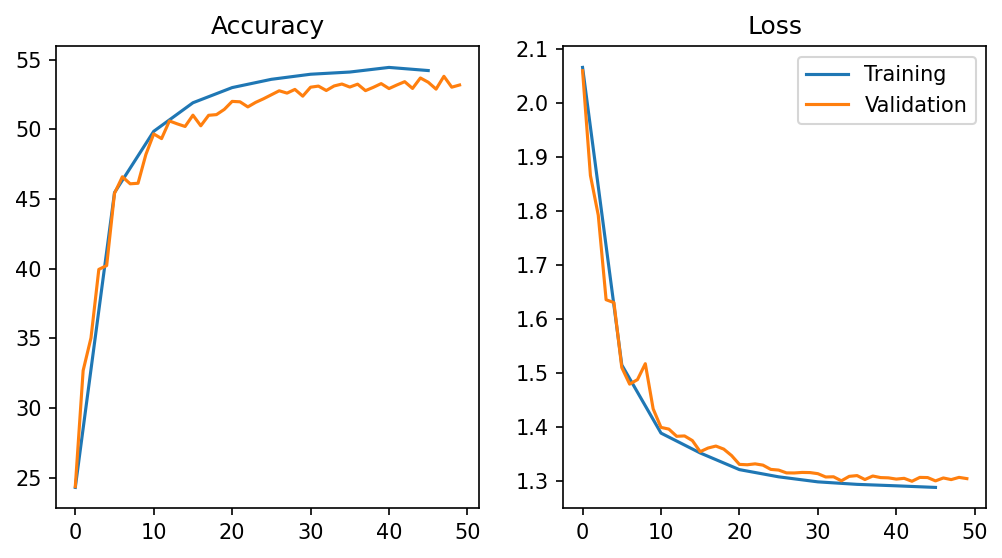

array([<Axes: title={'center': 'Accuracy'}>,
       <Axes: title={'center': 'Loss'}>], dtype=object)

In [32]:
plot_res(res_5)

# More filters

In [33]:
model_6 = Classifier(64, 4, 2).to(device=dev)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_6.parameters(), lr=0.01, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, gamma=0.5)

In [34]:
res_6 = train_model(model_6, loss_fn, optimizer, scheduler, 50, train_dataloader, val_dataloader)

Train Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: training loss: 1.998, accuracy: 24.960


Validate Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0: validation loss: 2.000, accuracy: 24.634


Train Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1: validation loss: 1.934, accuracy: 31.477


Train Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2: validation loss: 1.619, accuracy: 41.327


Train Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3: validation loss: 1.715, accuracy: 36.244


Train Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4: validation loss: 1.531, accuracy: 43.265


Train Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: training loss: 1.460, accuracy: 47.347


Validate Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: validation loss: 1.467, accuracy: 46.420


Train Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6: validation loss: 1.495, accuracy: 45.985


Train Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7: validation loss: 1.446, accuracy: 47.953


Train Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8: validation loss: 1.411, accuracy: 49.209


Train Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9: validation loss: 1.422, accuracy: 48.398


Train Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: training loss: 1.373, accuracy: 50.844


Validate Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10: validation loss: 1.380, accuracy: 49.743


Train Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11: validation loss: 1.372, accuracy: 50.049


Train Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12: validation loss: 1.384, accuracy: 49.921


Train Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13: validation loss: 1.353, accuracy: 50.821


Train Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14: validation loss: 1.351, accuracy: 51.434


Train Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15: training loss: 1.293, accuracy: 53.747


Validate Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15: validation loss: 1.306, accuracy: 52.462


Train Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16: validation loss: 1.306, accuracy: 52.502


Train Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17: validation loss: 1.303, accuracy: 52.749


Train Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18: validation loss: 1.312, accuracy: 52.324


Train Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19: validation loss: 1.289, accuracy: 53.224


Train Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20: training loss: 1.274, accuracy: 54.802


Validate Epoch 20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20: validation loss: 1.290, accuracy: 52.996


Train Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 21:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21: validation loss: 1.295, accuracy: 53.540


Train Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 22:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22: validation loss: 1.273, accuracy: 53.966


Train Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 23:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23: validation loss: 1.274, accuracy: 53.402


Train Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 24:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24: validation loss: 1.277, accuracy: 53.985


Train Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 25: training loss: 1.251, accuracy: 55.257


Validate Epoch 25:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25: validation loss: 1.263, accuracy: 54.134


Train Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 26:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26: validation loss: 1.255, accuracy: 54.618


Train Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 27:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27: validation loss: 1.262, accuracy: 54.361


Train Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 28:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28: validation loss: 1.262, accuracy: 54.193


Train Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 29:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29: validation loss: 1.255, accuracy: 54.579


Train Epoch 30:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 30:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 30: training loss: 1.230, accuracy: 56.158


Validate Epoch 30:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 30: validation loss: 1.249, accuracy: 54.895


Train Epoch 31:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 31:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 31: validation loss: 1.250, accuracy: 54.500


Train Epoch 32:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 32:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 32: validation loss: 1.247, accuracy: 55.083


Train Epoch 33:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 33:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 33: validation loss: 1.247, accuracy: 55.014


Train Epoch 34:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 34:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 34: validation loss: 1.252, accuracy: 54.648


Train Epoch 35:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 35: training loss: 1.224, accuracy: 56.462


Validate Epoch 35:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 35: validation loss: 1.243, accuracy: 55.231


Train Epoch 36:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 36:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 36: validation loss: 1.248, accuracy: 54.895


Train Epoch 37:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 37:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 37: validation loss: 1.250, accuracy: 54.846


Train Epoch 38:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 38:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 38: validation loss: 1.244, accuracy: 54.509


Train Epoch 39:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 39:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 39: validation loss: 1.243, accuracy: 54.519


Train Epoch 40:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 40: training loss: 1.223, accuracy: 56.540


Validate Epoch 40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 40: validation loss: 1.240, accuracy: 55.133


Train Epoch 41:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 41:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 41: validation loss: 1.246, accuracy: 54.598


Train Epoch 42:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 42:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 42: validation loss: 1.239, accuracy: 55.063


Train Epoch 43:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 43:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 43: validation loss: 1.246, accuracy: 54.796


Train Epoch 44:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 44:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 44: validation loss: 1.244, accuracy: 55.044


Train Epoch 45:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 45:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 45: training loss: 1.222, accuracy: 56.642


Validate Epoch 45:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 45: validation loss: 1.240, accuracy: 55.053


Train Epoch 46:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 46:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 46: validation loss: 1.240, accuracy: 55.469


Train Epoch 47:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 47:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 47: validation loss: 1.241, accuracy: 55.390


Train Epoch 48:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 48:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 48: validation loss: 1.242, accuracy: 55.083


Train Epoch 49:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 49:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 49: validation loss: 1.237, accuracy: 55.320


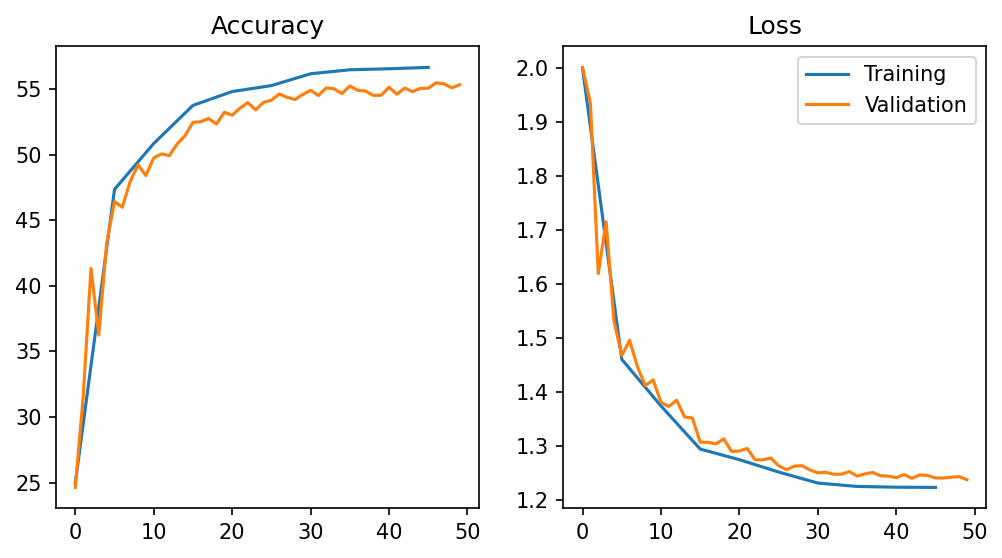

array([<Axes: title={'center': 'Accuracy'}>,
       <Axes: title={'center': 'Loss'}>], dtype=object)

In [35]:
plot_res(res_6)

# Large model: 4 stages, 3 blocks each, 64 initial filters

In [21]:
model_7 = Classifier(64, 4, 3).to(device=dev)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_7.parameters(), lr=0.01, weight_decay=0.01, momentum=0.9, nesterov=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, gamma=0.5)

In [22]:
print(summary(model_7, input_size=(batch_size, 3, 32, 32)))

Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [128, 10]                 --
├─Conv2d: 1-1                            [128, 64, 32, 32]         256
├─LayerNorm: 1-2                         [128, 64, 32, 32]         131,072
├─Sequential: 1-3                        [128, 512, 4, 4]          --
│    └─ConvNextBlock: 2-1                [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 64, 32, 32]         3,200
│    │    └─LayerNorm: 3-2               [128, 64, 32, 32]         131,072
│    │    └─Conv2d: 3-3                  [128, 256, 32, 32]        16,640
│    │    └─Conv2d: 3-4                  [128, 64, 32, 32]         16,448
│    └─ConvNextBlock: 2-2                [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-5                  [128, 64, 32, 32]         3,200
│    │    └─LayerNorm: 3-6               [128, 64, 32, 32]         131,072
│    │    └─Conv2d: 3-7                  [128, 256, 32,

In [23]:
res_7 = train_model(model_7, loss_fn, optimizer, scheduler, 50, train_dataloader, val_dataloader)

Train Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: training loss: 2.072, accuracy: 24.933


Validate Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0: validation loss: 2.078, accuracy: 24.179


Train Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1: validation loss: 1.701, accuracy: 37.302


Train Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2: validation loss: 1.646, accuracy: 40.585


Train Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3: validation loss: 1.688, accuracy: 39.349


Train Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4: validation loss: 1.641, accuracy: 39.844


Train Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: training loss: 1.517, accuracy: 45.005


Validate Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: validation loss: 1.509, accuracy: 44.907


Train Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6: validation loss: 1.551, accuracy: 43.720


Train Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7: validation loss: 1.683, accuracy: 41.416


Train Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8: validation loss: 1.537, accuracy: 44.996


Train Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9: validation loss: 1.571, accuracy: 43.987


Train Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: training loss: 1.445, accuracy: 47.928


Validate Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10: validation loss: 1.449, accuracy: 47.221


Train Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11: validation loss: 1.442, accuracy: 47.340


Train Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12: validation loss: 1.368, accuracy: 49.713


Train Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13: validation loss: 1.405, accuracy: 49.377


Train Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14: validation loss: 1.511, accuracy: 45.243


Train Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15: training loss: 1.318, accuracy: 52.681


Validate Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15: validation loss: 1.327, accuracy: 51.849


Train Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16: validation loss: 1.380, accuracy: 50.396


Train Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17: validation loss: 1.356, accuracy: 50.692


Train Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18: validation loss: 1.376, accuracy: 50.277


Train Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19: validation loss: 1.368, accuracy: 49.951


Train Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20: training loss: 1.281, accuracy: 53.976


Validate Epoch 20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20: validation loss: 1.312, accuracy: 51.820


Train Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 21:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21: validation loss: 1.348, accuracy: 51.335


Train Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 22:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22: validation loss: 1.337, accuracy: 51.295


Train Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 23:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23: validation loss: 1.304, accuracy: 52.354


Train Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 24:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24: validation loss: 1.313, accuracy: 52.591


Train Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 25: training loss: 1.260, accuracy: 55.000


Validate Epoch 25:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25: validation loss: 1.284, accuracy: 53.580


Train Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 26:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26: validation loss: 1.303, accuracy: 52.314


Train Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 27:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27: validation loss: 1.298, accuracy: 52.640


Train Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 28:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28: validation loss: 1.271, accuracy: 54.114


Train Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 29:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29: validation loss: 1.286, accuracy: 53.738


Train Epoch 30:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 30:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 30: training loss: 1.251, accuracy: 55.391


Validate Epoch 30:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 30: validation loss: 1.268, accuracy: 53.768


Train Epoch 31:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 31:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 31: validation loss: 1.267, accuracy: 53.906


Train Epoch 32:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 32:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 32: validation loss: 1.274, accuracy: 53.778


Train Epoch 33:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 33:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 33: validation loss: 1.285, accuracy: 52.967


Train Epoch 34:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 34:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 34: validation loss: 1.258, accuracy: 53.867


Train Epoch 35:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 35: training loss: 1.235, accuracy: 55.341


Validate Epoch 35:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 35: validation loss: 1.257, accuracy: 54.272


Train Epoch 36:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 36:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 36: validation loss: 1.256, accuracy: 54.064


Train Epoch 37:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 37:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 37: validation loss: 1.257, accuracy: 54.796


Train Epoch 38:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 38:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 38: validation loss: 1.252, accuracy: 54.777


Train Epoch 39:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 39:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 39: validation loss: 1.261, accuracy: 53.669


Train Epoch 40:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 40: training loss: 1.231, accuracy: 55.806


Validate Epoch 40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 40: validation loss: 1.260, accuracy: 54.163


Train Epoch 41:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 41:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 41: validation loss: 1.246, accuracy: 54.569


Train Epoch 42:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 42:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 42: validation loss: 1.253, accuracy: 54.401


Train Epoch 43:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 43:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 43: validation loss: 1.249, accuracy: 54.223


Train Epoch 44:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 44:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 44: validation loss: 1.247, accuracy: 55.222


Train Epoch 45:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 45:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 45: training loss: 1.222, accuracy: 56.075


Validate Epoch 45:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 45: validation loss: 1.245, accuracy: 54.411


Train Epoch 46:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 46:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 46: validation loss: 1.248, accuracy: 54.697


Train Epoch 47:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 47:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 47: validation loss: 1.243, accuracy: 54.598


Train Epoch 48:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 48:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 48: validation loss: 1.248, accuracy: 54.816


Train Epoch 49:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 49:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 49: validation loss: 1.245, accuracy: 54.856


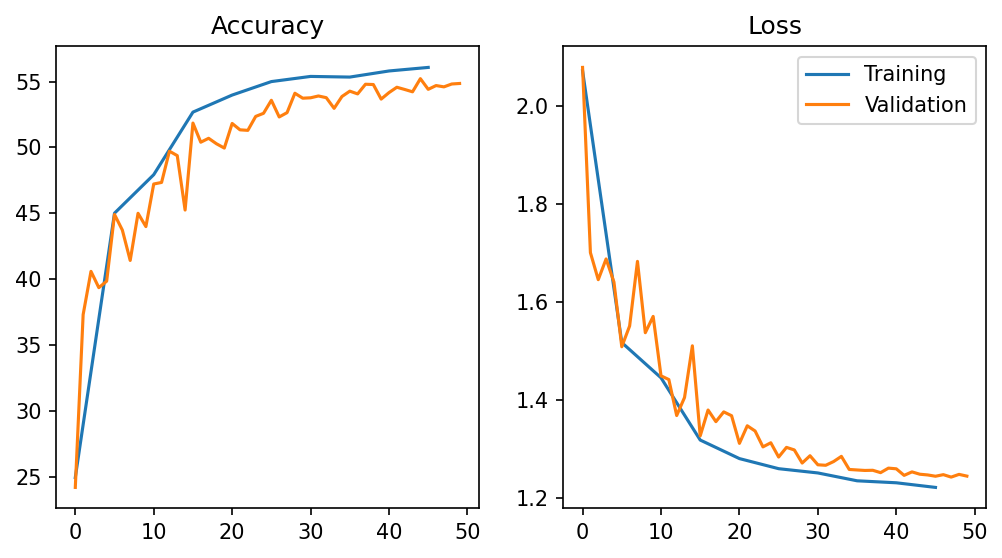

array([<Axes: title={'center': 'Accuracy'}>,
       <Axes: title={'center': 'Loss'}>], dtype=object)

In [24]:
plot_res(res_7)

# My go at it

This is a network based off of my previous attempt to get >90% accuracy on CIFAR10 data set (https://github.com/arminshzd/CIFAR10-CNN/blob/main/CIFAR10_CNN.ipynb), which is itself based on [this](https://github.com/fenwickslab/fenwicks/blob/master/tutorials/tutorial2_cifar10.ipynb) work.

The overall architecture is pretty similar to before, but significantly larger (2M parameters vs. 16M). The model is built from residual blocks (Resblock class) that have a single 2D convolution followed by batch normalization and ReLU activation. These residual blocks are then used in a residual layer (Reslayer) where the input goes through a Resblock and a MaxPool layer, then breaks off into two signals, each going through a separate Resblock and then summed back together.

The optimizer uses Nesterov momentum=0.9 to deal with the noise on the training data as well as preventing the possible overshooting during the optimization steps.

In [76]:
class Resblock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        super(Resblock, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                            kernel_size=kernel_size, stride=stride, padding='same')
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        return self.activation(x)


class Reslayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        super(Reslayer, self).__init__()
        self.res1 = Resblock(in_channels=in_channels, out_channels=out_channels, 
                             kernel_size=kernel_size, stride=stride)
        self.mp = nn.MaxPool2d(kernel_size=2)
        self.res2 = Resblock(in_channels=out_channels, out_channels=out_channels, 
                             kernel_size=kernel_size, stride=stride)
        self.res3 = Resblock(in_channels=out_channels, out_channels=out_channels, 
                             kernel_size=kernel_size, stride=stride)
        
    def forward(self, inputs):
        x = self.res1(inputs)
        x = self.mp(x)
        y = self.res2(x)
        y = self.res3(y)
        return x+y
    
class CIFAR_ResNet(nn.Module):
    def __init__(self):
        super(CIFAR_ResNet, self).__init__()
        # prep
        self.resb0 = Resblock(in_channels=3, out_channels=64, kernel_size=3, stride=1)
        # layer 1
        self.resl1 = Reslayer(64, 128, 3, 1)
        # layer 2
        self.resb2 = Resblock(in_channels=128, out_channels=256, kernel_size=3, stride=1)
        self.mp2 = nn.MaxPool2d(kernel_size=2)
        # layer 3
        self.resl3 = Reslayer(256, 512, 3, 1)
        # layer 4
        self.resb4 = Resblock(in_channels=512, out_channels=512, kernel_size=3, stride=1)
        self.mp4 = nn.MaxPool2d(kernel_size=2)
        # layer 5
        self.resl5 = Reslayer(512, 512, 3, 1)
        # classifier
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(512, 10)

    def forward(self, inputs):
        x = self.resb0(inputs)
        x = self.resl1(x)
        x = self.resb2(x)
        x = self.mp2(x)
        x = self.resl3(x)
        x = self.resb4(x)
        x = self.mp4(x)
        x = self.resl5(x)
        # head
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [80]:
def train_model(model, loss_fn, optimizer, scheduler, epochs, train_dl, val_dl):
    t_epochs = []
    accs_t = []
    losses_t = []
    accs_v = []
    losses_v = []
    for j in range(epochs):
        with tqdm(total=len(train_dl), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
            train_one_epoch(train_dl, model, loss_fn, optimizer, train_bar)
        
        # checking on the training & validation loss & accuracy 
        # for training data - only once every 5 epochs (takes a while) 
        if j % 5 == 0:
            with tqdm(total=len(train_dl), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
                acc, loss = evaluate(train_dl, model, loss_fn, train_eval)
                t_epochs.append(j)
                accs_t.append(acc)
                losses_t.append(loss)
                print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
                
        with tqdm(total=len(val_dl), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:
        
            acc_val, loss_val = evaluate(val_dl, model, loss_fn, val_bar)
            accs_v.append(acc_val)
            losses_v.append(loss_val)
            print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")
        scheduler.step(loss_val)
    return {"train_epochs": t_epochs, "train_accs": accs_t, "train_losses": losses_t, "val_accs": accs_v, "val_losses": losses_v}

In [81]:
model_mine = CIFAR_ResNet().to(device=dev)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_mine.parameters(), lr=0.01, weight_decay=0.01, momentum=0.9, nesterov=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)

In [82]:
print(summary(model_mine, input_size=(batch_size, 3, 32, 32)))

Layer (type:depth-idx)                   Output Shape              Param #
CIFAR_ResNet                             [128, 10]                 --
├─Resblock: 1-1                          [128, 64, 32, 32]         --
│    └─Conv2d: 2-1                       [128, 64, 32, 32]         1,792
│    └─BatchNorm2d: 2-2                  [128, 64, 32, 32]         128
│    └─ReLU: 2-3                         [128, 64, 32, 32]         --
├─Reslayer: 1-2                          [128, 128, 16, 16]        --
│    └─Resblock: 2-4                     [128, 128, 32, 32]        --
│    │    └─Conv2d: 3-1                  [128, 128, 32, 32]        73,856
│    │    └─BatchNorm2d: 3-2             [128, 128, 32, 32]        256
│    │    └─ReLU: 3-3                    [128, 128, 32, 32]        --
│    └─MaxPool2d: 2-5                    [128, 128, 16, 16]        --
│    └─Resblock: 2-6                     [128, 128, 16, 16]        --
│    │    └─Conv2d: 3-4                  [128, 128, 16, 16]        147,584
│

In [83]:
res_mine = train_model(model_mine, loss_fn, optimizer, scheduler, 50, train_dataloader, val_dataloader)

Train Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: training loss: 1.179, accuracy: 57.176


Validate Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0: validation loss: 1.209, accuracy: 55.518


Train Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1: validation loss: 1.120, accuracy: 61.828


Train Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2: validation loss: 0.834, accuracy: 70.965


Train Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3: validation loss: 0.907, accuracy: 67.642


Train Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4: validation loss: 0.961, accuracy: 66.446


Train Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: training loss: 0.620, accuracy: 79.091


Validate Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: validation loss: 0.677, accuracy: 76.088


Train Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6: validation loss: 0.852, accuracy: 69.947


Train Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7: validation loss: 0.633, accuracy: 77.522


Train Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8: validation loss: 1.205, accuracy: 60.908


Train Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9: validation loss: 0.653, accuracy: 77.611


Train Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: training loss: 0.608, accuracy: 79.063


Validate Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10: validation loss: 0.671, accuracy: 76.068


Train Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11: validation loss: 0.747, accuracy: 73.695


Train Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12: validation loss: 0.793, accuracy: 71.707


Train Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13: validation loss: 1.223, accuracy: 59.415


Train Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14: validation loss: 0.677, accuracy: 77.403


Train Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15: training loss: 0.390, accuracy: 87.313


Validate Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15: validation loss: 0.522, accuracy: 81.428


Train Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16: validation loss: 0.522, accuracy: 81.576


Train Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17: validation loss: 0.607, accuracy: 78.906


Train Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18: validation loss: 0.903, accuracy: 69.917


Train Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19: validation loss: 0.720, accuracy: 75.158


Train Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20: training loss: 0.408, accuracy: 86.589


Validate Epoch 20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20: validation loss: 0.533, accuracy: 81.735


Train Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 21:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21: validation loss: 0.561, accuracy: 79.796


Train Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 22:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22: validation loss: 0.361, accuracy: 87.174


Train Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 23:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23: validation loss: 0.378, accuracy: 86.640


Train Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 24:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24: validation loss: 0.520, accuracy: 82.288


Train Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 25: training loss: 0.199, accuracy: 93.633


Validate Epoch 25:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25: validation loss: 0.419, accuracy: 85.710


Train Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 26:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26: validation loss: 0.436, accuracy: 85.285


Train Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 27:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27: validation loss: 0.578, accuracy: 80.904


Train Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 28:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28: validation loss: 0.533, accuracy: 82.288


Train Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 29:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29: validation loss: 0.292, accuracy: 89.844


Train Epoch 30:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 30:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 30: training loss: 0.055, accuracy: 98.692


Validate Epoch 30:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 30: validation loss: 0.298, accuracy: 89.676


Train Epoch 31:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 31:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 31: validation loss: 0.325, accuracy: 88.746


Train Epoch 32:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 32:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 32: validation loss: 0.302, accuracy: 89.913


Train Epoch 33:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 33:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 33: validation loss: 0.333, accuracy: 88.934


Train Epoch 34:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 34:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 34: validation loss: 0.361, accuracy: 87.935


Train Epoch 35:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 35: training loss: 0.100, accuracy: 96.985


Validate Epoch 35:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 35: validation loss: 0.396, accuracy: 86.917


Train Epoch 36:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 36:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 36: validation loss: 0.282, accuracy: 90.744


Train Epoch 37:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 37:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 37: validation loss: 0.254, accuracy: 91.110


Train Epoch 38:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 38:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 38: validation loss: 0.269, accuracy: 90.793


Train Epoch 39:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 39:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 39: validation loss: 0.247, accuracy: 91.248


Train Epoch 40:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 40:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 40: training loss: 0.019, accuracy: 99.760


Validate Epoch 40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 40: validation loss: 0.252, accuracy: 91.238


Train Epoch 41:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 41:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 41: validation loss: 0.258, accuracy: 91.080


Train Epoch 42:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 42:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 42: validation loss: 0.262, accuracy: 91.040


Train Epoch 43:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 43:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 43: validation loss: 0.260, accuracy: 90.882


Train Epoch 44:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 44:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 44: validation loss: 0.271, accuracy: 90.951


Train Epoch 45:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 45:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 45: training loss: 0.018, accuracy: 99.753


Validate Epoch 45:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 45: validation loss: 0.256, accuracy: 91.446


Train Epoch 46:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 46:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 46: validation loss: 0.243, accuracy: 91.841


Train Epoch 47:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 47:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 47: validation loss: 0.244, accuracy: 91.634


Train Epoch 48:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 48:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 48: validation loss: 0.233, accuracy: 92.049


Train Epoch 49:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 49:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 49: validation loss: 0.231, accuracy: 92.049


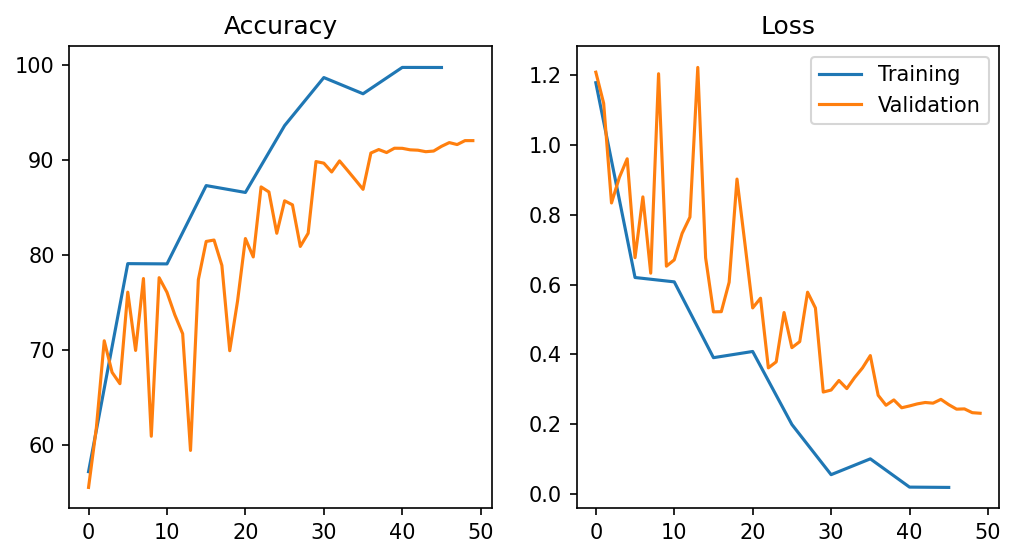

array([<Axes: title={'center': 'Accuracy'}>,
       <Axes: title={'center': 'Loss'}>], dtype=object)

In [84]:
plot_res(res_mine)

In [97]:
test_dataloader = torch.utils.data.DataLoader(test_data, 
    batch_size=batch_size, 
    pin_memory=True,
    shuffle=False, 
    num_workers=2)

In [99]:
model_mine.eval()
loss, correct = 0, 0
with torch.no_grad():
    # loop over all of the batches
    for X, y in test_dataloader:

        pred = model_mine(X.to(dev)).detach().cpu()
        loss += loss_fn(pred, y).item()
        # how many are correct in this batch? Tracking for accuracy 
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
loss /= len(test_dataloader)
correct /= (len(test_dataloader)*batch_size)

accuracy = 100*correct
print(f"Test data loss: {loss}\t accuracy: {accuracy}")

Test data loss: 0.23857544390838356	 accuracy: 91.7128164556962


91% accuracy on the test data, a significant improvement from the previous architecture.